In [1]:
# importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torchvision.transforms as transforms
import torch
import torchvision

## Checking for Cuda

In [2]:
# checking if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


## Loading and Data Transforming CIFAR-10 dataset

In [ ]:
# defining data transformations for training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),  # Randomly crop the image with reflection padding
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((-0.0028, -0.0045, -0.0044), (1.2187, 1.2189, 1.2989))  # Normalize the image tensor
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((-0.0028, -0.0045, -0.0044), (1.2187, 1.2189, 1.2989))  # Normalize the image tensor
])

# loading CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# DataLoader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=3)

# loading CIFAR-10 testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
# DataLoader for the testing dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=3)

# Referenced from:
# Das, K. (2020). CIFAR10 ResNet: 90+% accuracy;less than 5 min. Kaggle. Retrieved April 9, 2024, from
# https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

Files already downloaded and verified
Files already downloaded and verified


## ResNet18 Architecture

In [4]:
# adopted from week 8 ResNet lab  
# defining a Residual Block module for the ResNet architecture
class ResNetBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResNetBlock, self).__init__()

        # First convolutional layer with batch normalization and ReLU activation
        self.conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = torch.nn.BatchNorm2d(output_channels)
        self.relu1 = torch.nn.ReLU()

        # Second convolutional layer with batch normalization
        self.conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channels)

        # Third convolutional layer for adjusting dimensions which is optional
        self.conv3 = None
        if (input_channels != output_channels) or (stride != 1):
            self.conv3 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride)

        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        # passing through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        # passing through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # apply the third convolutional layer and add the residual, which is optional 
        if self.conv3:
            out += self.conv3(x)
        else:
            out += x

        # applying ReLU activation to the output
        return self.relu2(out)

In [5]:
# adopted from week 8 ResNet lab 
# macroblock in the ResNet architecture with two ResNet blocks
class ResNetMacroblock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, first_macroblock=False):
        super(ResNetMacroblock, self).__init__()

        # determining the stride if it is the first macroblock or not
        s = 1 if first_macroblock else 2

        # first ResNet block
        self.rb1 = ResNetBlock(input_channels, output_channels, stride=s)
        # second ResNet block
        self.rb2 = ResNetBlock(output_channels, output_channels, stride=1)

    # passing through the macroblock
    def forward(self, x):
        # passing through the first ResNet block
        out = self.rb1(x)
        # passing through the second ResNet block
        out = self.rb2(out)
        return out

In [6]:
# adopted from week 8 ResNet lab 
# defining ResNet18 architecture
class ResNet18(torch.nn.Module):
    def __init__(self, num_outputs):
        super(ResNet18, self).__init__()

        # number of output classes
        self.num_outputs = num_outputs

        # initial convolutional layer
        self.conv = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) 
        # batch normalization layer
        self.bn = torch.nn.BatchNorm2d(64)
        # activation function
        self.relu = torch.nn.ReLU()
        # max pooling layer
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet macroblocks
        self.rmb1 = ResNetMacroblock(64, 64, first_macroblock=True)
        self.rmb2 = ResNetMacroblock(64, 128)
        self.rmb3 = ResNetMacroblock(128, 256)
        self.rmb4 = ResNetMacroblock(256, 512)

        # adaptive average pooling layer
        self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))
        # flatting the output tensor
        self.flatten = torch.nn.Flatten()
        # defining the fully connected layer for classification
        self.linear = torch.nn.Linear(512, self.num_outputs)

    # passing through the network
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.rmb1(out)
        out = self.rmb2(out)
        out = self.rmb3(out)
        out = self.rmb4(out)

        out = self.channel_avg(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out


In [7]:
# Applies Xavier initialization 
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

# an instance of the ResNet18 model with 10 output classes and moving it to the device
model = ResNet18(10).to(device) 

model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

ResNet18(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (rmb1): ResNetMacroblock(
    (rb1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (rb2): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_siz

## Loss function


In [8]:
# calculating loss with Cross Entropy Loss
criterion = torch.nn.CrossEntropyLoss()

## Optimization Algorithm


In [9]:
# Adam optimizer with learning rate 0.02
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Referenced from:
# Das, K. (2020). CIFAR10 ResNet: 90+% accuracy;less than 5 min. Kaggle. Retrieved April 9, 2024, from
# https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

## Learning Rate Scheduler

In [10]:
# learning rate scheduler with OneCycleLR, starting lr=0.02, total epochs=30, and steps per epoch equal to the length of the trainloader
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, total_steps=30*len(trainloader))

# Referenced from:
# Das, K. (2020). CIFAR10 ResNet: 90+% accuracy;less than 5 min. Kaggle. Retrieved April 9, 2024, from
# https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

## Training and Testing 

In [11]:
# Initializing variables 
train_correct_total = 0
train_total_samples = 0
test_correct_total = 0
test_total_samples = 0
train_losses = []  
train_accuracies = []  
test_accuracies = []  

# Training the network
def train(epoch):
    global train_correct_total, train_total_samples
    print("Epoch " + str(epoch))
    model.train()  # setting model to training mode
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, targets) 
        loss.backward()  
        optimizer.step()  

        train_loss += loss.item()  
        _, predicted = outputs.max(1) 
        total += targets.size(0)  
        correct += predicted.eq(targets).sum().item()  
    
    # collecting correct predictions and total samples for training
    train_correct_total += correct
    train_total_samples += total
    train_accuracy = 100.*correct/total  # calculating training accuracy
    train_accuracies.append(train_accuracy)  
    train_losses.append(train_loss / len(trainloader))  

    print('Train Accuracy: ' +  str(train_accuracy))

# Testing the network
def test(epoch):
    global best_acc, test_correct_total, test_total_samples
    model.eval()  # setting model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, targets) 

            test_loss += loss.item() 
            _, predicted = outputs.max(1) 
            total += targets.size(0)  
            correct += predicted.eq(targets).sum().item()  
    
    # collecting correct predictions and total samples for testing
    test_correct_total += correct
    test_total_samples += total
    test_accuracy = 100.*correct/total  # calculating testing accuracy
    test_accuracies.append(test_accuracy)  

    print('Test Accuracy: ' +  str(test_accuracy))

best_acc = 0
best_epoch = 0
start_epoch = 0
num_epochs = 30

for epoch in range(start_epoch, start_epoch+num_epochs):
    scheduler.step()  # updating the learning rate scheduler
    train(epoch)  # training model for one epoch
    test(epoch)  # testing model on the testing dataset
    
    if test_accuracies[-1] > best_acc:
        best_acc = test_accuracies[-1]
        best_epoch = epoch
        
print("Best Test Accuracy: {:.2f}% achieved at epoch {}".format(best_acc, best_epoch))


Epoch 0


/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Train Accuracy: 50.178
Test Accuracy: 58.64
Epoch 1
Train Accuracy: 66.26
Test Accuracy: 70.21
Epoch 2
Train Accuracy: 72.672
Test Accuracy: 76.01
Epoch 3
Train Accuracy: 76.252
Test Accuracy: 68.66
Epoch 4
Train Accuracy: 79.114
Test Accuracy: 78.76
Epoch 5
Train Accuracy: 81.148
Test Accuracy: 77.1
Epoch 6
Train Accuracy: 82.568
Test Accuracy: 80.82
Epoch 7
Train Accuracy: 83.954
Test Accuracy: 82.32
Epoch 8
Train Accuracy: 84.982
Test Accuracy: 82.74
Epoch 9
Train Accuracy: 85.972
Test Accuracy: 83.15
Epoch 10
Train Accuracy: 86.634
Test Accuracy: 82.39
Epoch 11
Train Accuracy: 87.258
Test Accuracy: 84.8
Epoch 12
Train Accuracy: 88.5
Test Accuracy: 84.17
Epoch 13
Train Accuracy: 88.784
Test Accuracy: 83.76
Epoch 14
Train Accuracy: 89.278
Test Accuracy: 85.69
Epoch 15
Train Accuracy: 89.86
Test Accuracy: 85.9
Epoch 16
Train Accuracy: 90.364
Test Accuracy: 84.68
Epoch 17
Train Accuracy: 90.744
Test Accuracy: 86.41
Epoch 18
Train Accuracy: 91.23
Test Accuracy: 87.78
Epoch 19
Train Accu

## Plotting Results

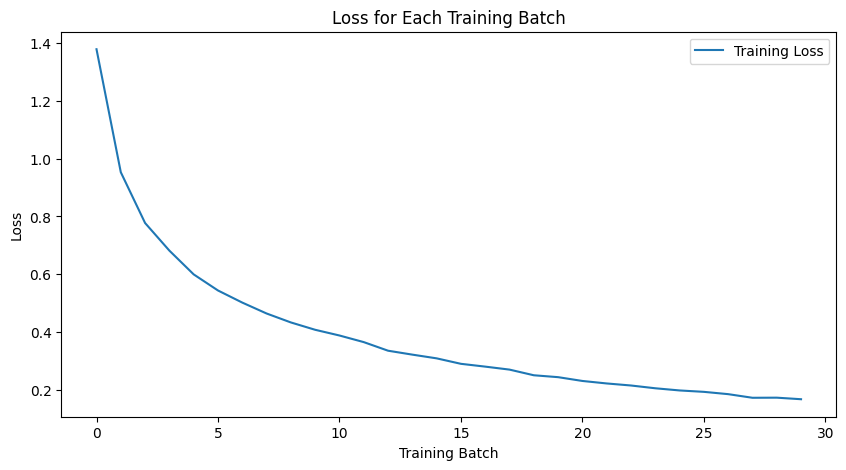

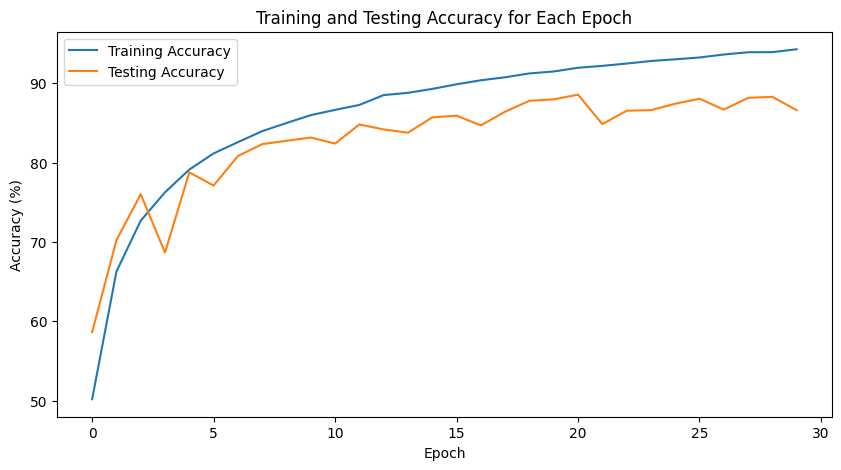

In [12]:
# plotting loss for each training batch
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Training Batch')
plt.ylabel('Loss')
plt.title('Loss for Each Training Batch')
plt.legend()
plt.show()

# plotting training and testing accuracy for each training epoch
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(start_epoch, num_epochs), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy for Each Epoch')
plt.legend()
plt.show()